In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 1. Setup and Data Loading

In [18]:
# Load burglary data and filter for 2019
burglary = pd.read_csv("data/burglary.csv")
burglary = burglary[burglary["Year"] == 2019]

# Aggregate total burglaries per ward
ward_burglary = burglary.groupby("Ward Code").size().reset_index(name="Burglary Count")
total_burglaries = ward_burglary["Burglary Count"].sum()
ward_burglary["Burglary Pct"] = (ward_burglary["Burglary Count"] / total_burglaries) * 100

# Load Ward-level IMD data
imd_ward = pd.read_excel("data/imd2019_wards.xlsx")

# Merge burglary data with IMD data
merged = pd.merge(ward_burglary, imd_ward, on="Ward Code", how="inner")

# Select key IMD factors
imd_vars = [
    "IMD average score",
    "Income score",
    "Employment score",
    "IDACI score",
    "IDAOPI score",
]

## 2. Data Exploration

===== DATA EXPLORATION =====
Number of wards analyzed: 149

Basic statistics for burglary percentage:
count    149.000000
mean       0.154936
std        0.068551
min        0.031686
25%        0.109001
50%        0.139421
75%        0.192654
max        0.424599
Name: Burglary Pct, dtype: float64


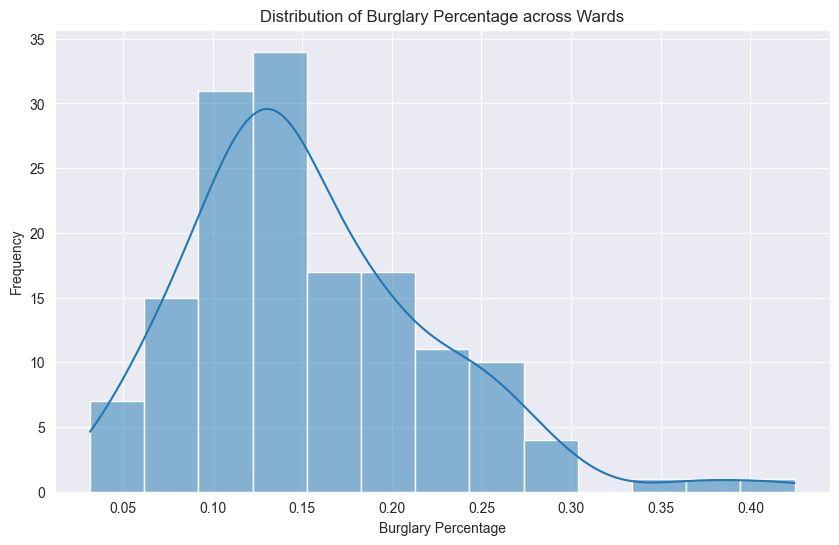

In [19]:
print("===== DATA EXPLORATION =====")
print(f"Number of wards analyzed: {merged.shape[0]}")
print("\nBasic statistics for burglary percentage:")
print(merged["Burglary Pct"].describe())

# Visualize the distribution of burglary percentage
plt.figure(figsize=(10, 6))
sns.histplot(merged["Burglary Pct"], kde=True)
plt.title("Distribution of Burglary Percentage across Wards")
plt.xlabel("Burglary Percentage")
plt.ylabel("Frequency")
plt.show()

## 3. Correlation Analysis

Correlations with Burglary Percentage:
IDAOPI score         0.414614
IDACI score          0.330219
IMD average score    0.311765
Income score         0.214818
Employment score     0.104420
Name: Burglary Pct, dtype: float64


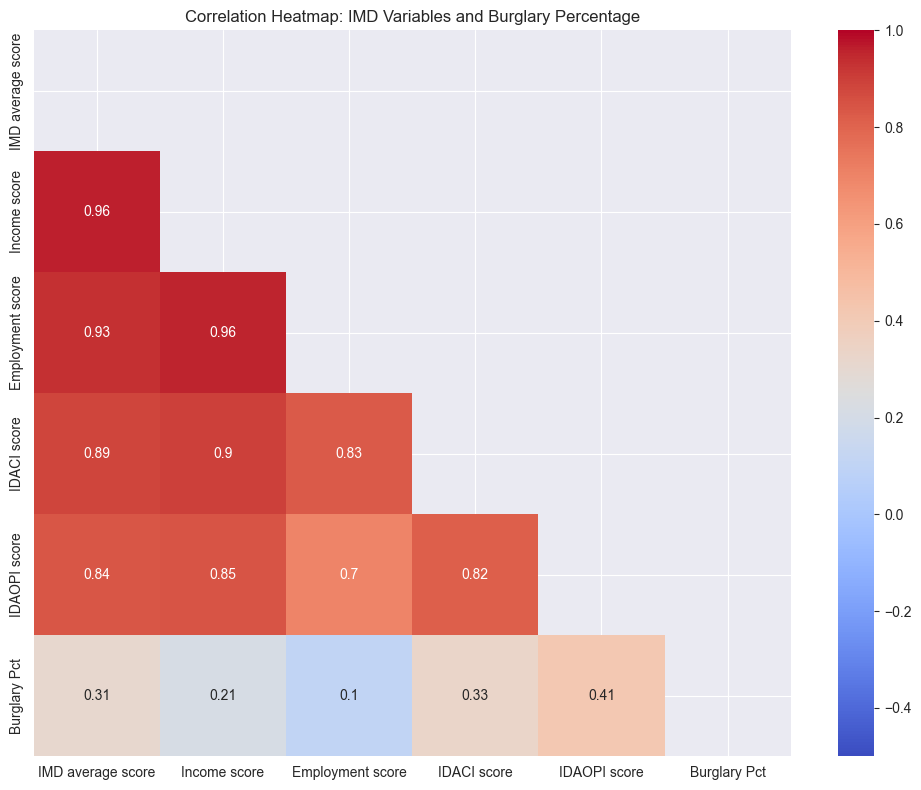

In [20]:
# Calculate correlations with burglary percentage
correlations = (
    merged[imd_vars + ["Burglary Pct"]]
    .corr()["Burglary Pct"]
    .sort_values(ascending=False)
)
print("Correlations with Burglary Percentage:")
print(correlations.drop("Burglary Pct"))

# Create correlation heatmap
plt.figure(figsize=(10, 8))
corr_matrix = merged[imd_vars + ["Burglary Pct"]].corr()
mask = np.triu(corr_matrix)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-0.5, vmax=1, mask=mask)
plt.title("Correlation Heatmap: IMD Variables and Burglary Percentage")
plt.tight_layout()
plt.show()

## 4. Multicollinearity Assessment

In [21]:
# Calculate VIF for each predictor
X = merged[imd_vars]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("Variance Inflation Factors:")
print(vif_data.sort_values("VIF", ascending=False))

Variance Inflation Factors:
            Variable         VIF
1       Income score  265.579922
2   Employment score  187.634043
0  IMD average score  124.869286
4       IDAOPI score   37.801703
3        IDACI score   35.317857


## 5. Regression Models

In [22]:
# Prepare data
X = merged[imd_vars]
y = merged["Burglary Pct"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define a function to run and evaluate multiple regression models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print(f"\n{model_name} Results:")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")

    # Feature importance
    if hasattr(model, "coef_"):
        coefs = pd.Series(model.coef_, index=X.columns)
        print("\nFeature Importance:")
        print(coefs.sort_values(ascending=False))

    return model, train_r2, test_r2, test_rmse

## 5.1 OLS Regression with Detailed Statistics

In [23]:
# OLS Regression with statsmodels (for detailed statistics)
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)
sm_model = sm.OLS(y_train, X_train_sm).fit()
print("\nDetailed OLS Regression Results:")
print(sm_model.summary())

# Get p-values
p_values = sm_model.pvalues[1:]  # Skip the constant
significant_vars = [var for var, p in zip(imd_vars, p_values) if p < 0.05]
print("\nStatistically significant variables (p < 0.05):")
print(significant_vars)


Detailed OLS Regression Results:
                            OLS Regression Results                            
Dep. Variable:           Burglary Pct   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     12.07
Date:                Wed, 07 May 2025   Prob (F-statistic):           2.25e-09
Time:                        00:07:47   Log-Likelihood:                 183.47
No. Observations:                 119   AIC:                            -354.9
Df Residuals:                     113   BIC:                            -338.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
cons

## 5.2 Multiple Regression Models Comparison

In [24]:
# Multiple regression models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression (alpha=1.0)": Ridge(alpha=1.0),
    "Lasso Regression (alpha=0.1)": Lasso(alpha=0.1),
}

results = {}
for name, model in models.items():
    fitted_model, train_r2, test_r2, test_rmse = evaluate_model(
        model, X_train, X_test, y_train, y_test, name
    )
    results[name] = {
        "model": fitted_model,
        "train_r2": train_r2,
        "test_r2": test_r2,
        "rmse": test_rmse,
    }

# Compare models
results_df = pd.DataFrame(
    {
        "Training R²": [results[name]["train_r2"] for name in models.keys()],
        "Test R²": [results[name]["test_r2"] for name in models.keys()],
        "Test RMSE": [results[name]["rmse"] for name in models.keys()],
    },
    index=models.keys(),
)

print("\nModel Comparison:")
print(results_df)

# Find best model based on test R²
best_model_name = results_df["Test R²"].idxmax()
best_model = results[best_model_name]["model"]
print(f"\nBest performing model: {best_model_name}")


Linear Regression Results:
Training R²: 0.3481
Test R²: 0.4407
Test RMSE: 0.0606

Feature Importance:
IDACI score          0.407082
IDAOPI score         0.115555
IMD average score    0.008935
Income score        -0.914379
Employment score    -1.504168
dtype: float64

Ridge Regression (alpha=1.0) Results:
Training R²: 0.1242
Test R²: 0.1741
Test RMSE: 0.0736

Feature Importance:
IDAOPI score         0.081159
IDACI score          0.031881
IMD average score    0.000995
Income score        -0.039189
Employment score    -0.041421
dtype: float64

Lasso Regression (alpha=0.1) Results:
Training R²: 0.0401
Test R²: 0.0049
Test RMSE: 0.0808

Feature Importance:
IMD average score    0.00065
Income score         0.00000
Employment score    -0.00000
IDACI score          0.00000
IDAOPI score         0.00000
dtype: float64

Model Comparison:
                              Training R²   Test R²  Test RMSE
Linear Regression                0.348145  0.440727   0.060579
Ridge Regression (alpha=1.0)     0

## 6. Focused Analysis with Significant Variables

In [25]:
# Use only significant variables from OLS results
if significant_vars:
    # Train model with only significant variables
    X_sig_train = X_train[significant_vars]
    X_sig_test = X_test[significant_vars]

    sig_model = LinearRegression()
    sig_model.fit(X_sig_train, y_train)

    y_sig_train_pred = sig_model.predict(X_sig_train)
    y_sig_test_pred = sig_model.predict(X_sig_test)

    sig_train_r2 = r2_score(y_train, y_sig_train_pred)
    sig_test_r2 = r2_score(y_test, y_sig_test_pred)

    print(f"Model with only significant variables:")
    print(f"Variables: {significant_vars}")
    print(f"Training R²: {sig_train_r2:.4f}")
    print(f"Test R²: {sig_test_r2:.4f}")

    # Compare with full model
    print(f"\nR² comparison:")
    print(f"Full model: {results['Linear Regression']['test_r2']:.4f}")
    print(f"Significant variables only: {sig_test_r2:.4f}")

Model with only significant variables:
Variables: ['IMD average score', 'Employment score', 'IDACI score']
Training R²: 0.3302
Test R²: 0.4332

R² comparison:
Full model: 0.4407
Significant variables only: 0.4332


## 7. Prediction Visualization


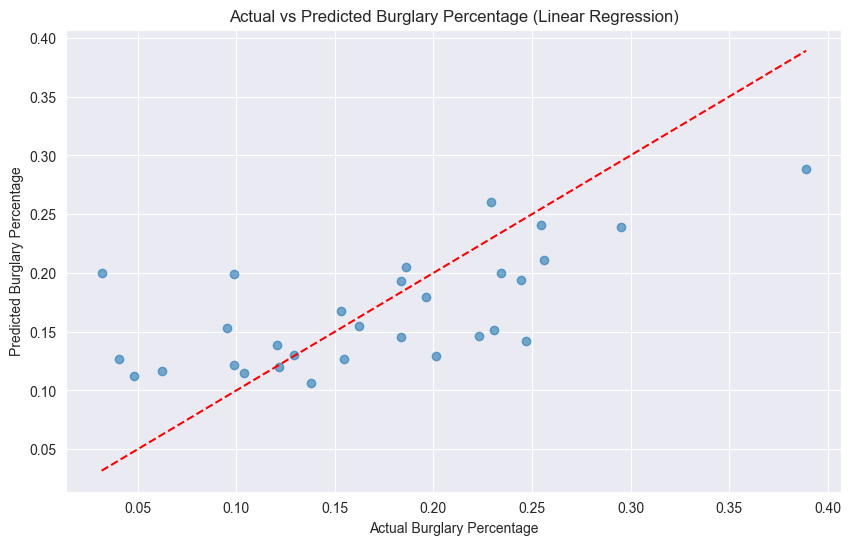

In [26]:
# Use best model for predictions
best_model = results[best_model_name]["model"]
y_pred = best_model.predict(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Burglary Percentage")
plt.ylabel("Predicted Burglary Percentage")
plt.title(f"Actual vs Predicted Burglary Percentage ({best_model_name})")
plt.show()

## 8. Individual Variable Analysis


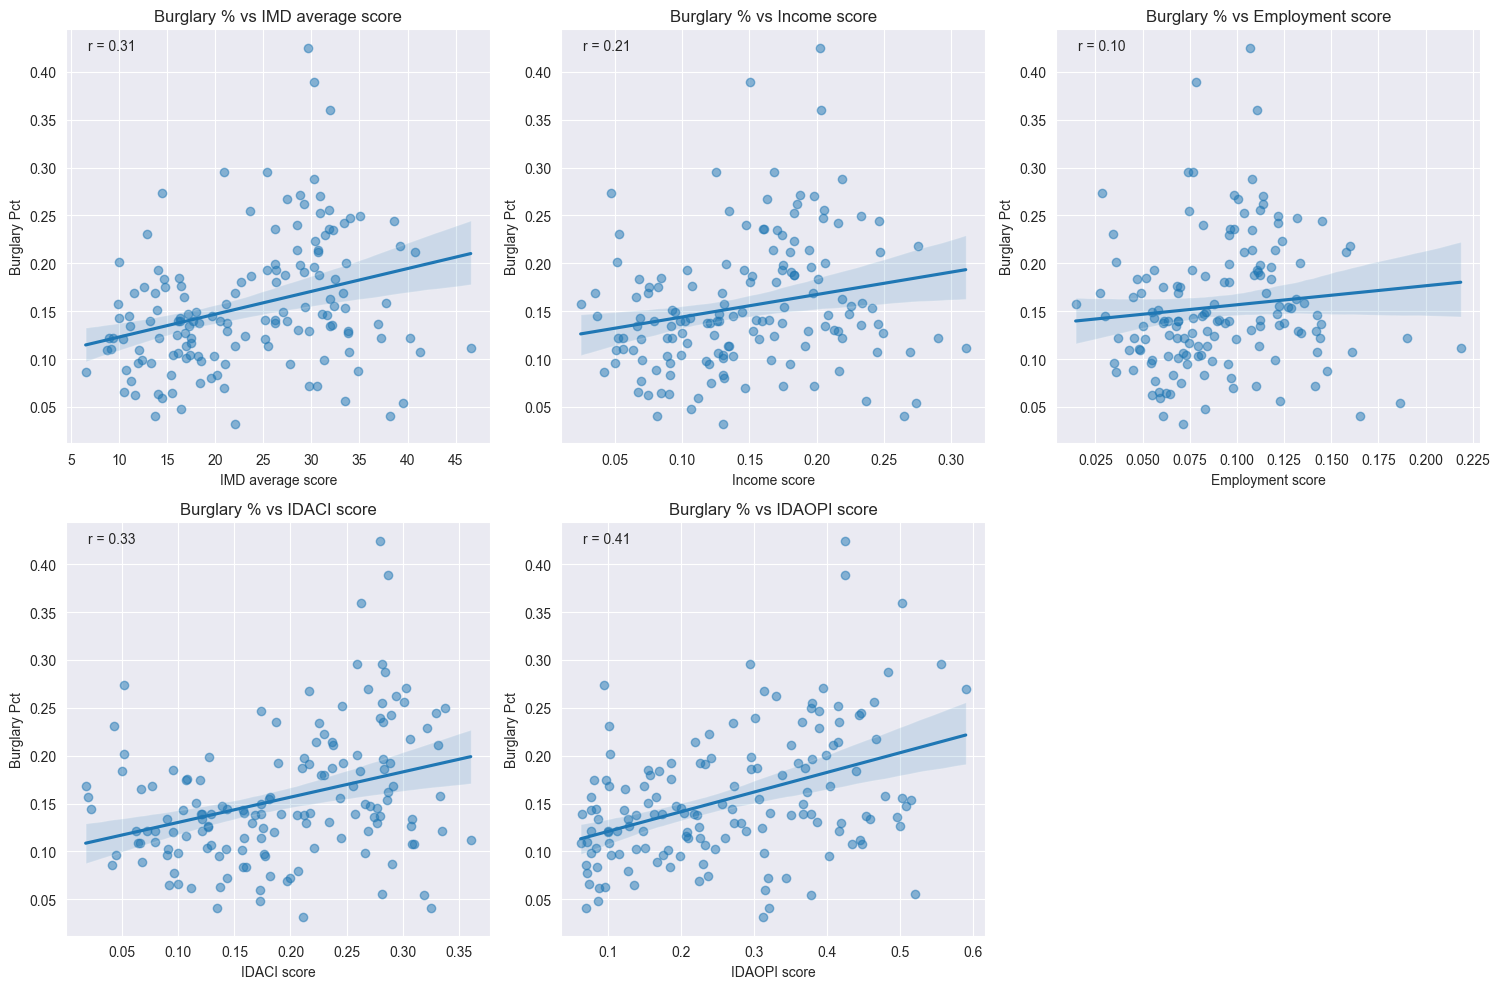

In [27]:
# Create scatterplots with regression lines
plt.figure(figsize=(15, 10))
for i, var in enumerate(imd_vars):
    plt.subplot(2, 3, i + 1)
    sns.regplot(x=var, y="Burglary Pct", data=merged, scatter_kws={"alpha": 0.5})
    plt.title(f"Burglary % vs {var}")

    # Calculate and display correlation
    corr = merged[[var, "Burglary Pct"]].corr().iloc[0, 1]
    plt.annotate(f"r = {corr:.2f}", xy=(0.05, 0.95), xycoords="axes fraction")

plt.tight_layout()
plt.show()

## 9. Interaction Effects Analysis


In [28]:
# Create interaction terms between top variables
top_vars = correlations.drop("Burglary Pct").nlargest(2).index.tolist()
var1, var2 = top_vars[0], top_vars[1]
merged["Interaction"] = merged[var1] * merged[var2]

# Test if interaction term improves the model
X_interact = X.copy()
X_interact["Interaction"] = merged["Interaction"]

X_interact_train, X_interact_test, y_interact_train, y_interact_test = train_test_split(
    X_interact, y, test_size=0.2, random_state=42
)

interact_model = LinearRegression()
interact_model.fit(X_interact_train, y_interact_train)
y_interact_pred = interact_model.predict(X_interact_test)
interact_r2 = r2_score(y_interact_test, y_interact_pred)

print(f"Interaction between {var1} and {var2}:")
print(f"Model with interaction term - Test R²: {interact_r2:.4f}")
print(f"Original model - Test R²: {results['Linear Regression']['test_r2']:.4f}")
print(f"Difference: {interact_r2 - results['Linear Regression']['test_r2']:.4f}")

Interaction between IDAOPI score and IDACI score:
Model with interaction term - Test R²: 0.4443
Original model - Test R²: 0.4407
Difference: 0.0035


## 10. Spatial Analysis


In [29]:
import geopandas as gpd
import libpysal
from esda.moran import Moran
from spreg import ML_Lag  # Spatial Lag Model

# Load ward boundaries and merge with your data
wards = gpd.read_file("data/wards_2018/London_Ward.shp")
merged_spatial = wards.merge(merged, left_on='GSS_CODE', right_on='Ward Code')

# Define variables
y = merged_spatial['Burglary Pct'].values.reshape(-1,1)
X = merged_spatial[imd_vars].values

# Queen contiguity weights (shared borders)
w = libpysal.weights.Queen.from_dataframe(merged_spatial)
w.transform = 'r'  # Row-standardize weights

# Check spatial autocorrelation
moran = Moran(y, w)
print(f"Moran's I: {moran.I:.3f}, p-value: {moran.p_sim:.3f}")

# Fit model
model = ML_Lag(y, X, w=w, name_y='Burglary Pct',
              name_x=imd_vars)

# Print results
print(model.summary)

C:\Users\gusta\AppData\Local\Temp\ipykernel_32468\3022294128.py:15: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(merged_spatial)
F:\Work\UniProject\MD_CBL\MD_CBL-Group_2\.venv\Lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


Moran's I: 0.389, p-value: 0.001
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Burglary Pct                Number of Observations:         149
Mean dependent var  :      0.1549                Number of Variables   :           7
S.D. dependent var  :      0.0686                Degrees of Freedom    :         142
Pseudo R-squared    :      0.4047
Spatial Pseudo R-squared:  0.3908
Log likelihood      :    226.6668
Sigma-square ML     :      0.0028                Akaike info criterion :    -439.334
S.E of regression   :      0.0527                Schwarz criterion     :    -418.306

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------